# Motivating example: Parallel image processing with scikit-image

To get a sense of what IPython.parallel might be used for,
we start with an example of some batch processing of image files with [scikit-image](http://scikit-image.org/).
We will revisit pieces of this example as we learn about the different components of IPython.

You can download images with [this notebook](../download-images.ipynb), or get a zip [here](https://s3.amazonaws.com/ipython-parallel-data/images.zip), or find any images on your computer.




In [19]:
import sys
import requests
from zipfile import ZipFile, BadZipFile
from IPython.html.widgets import IntProgress
from IPython.display import display

images = os.path.join('..', 'images')
images_url = "https://s3.amazonaws.com/ipython-parallel-data/images.zip"


def download_images():
    r = requests.get(images_url, stream=True)
    content_length = r.headers.get('content-length')
    print("Downloading images")
    sys.stdout.flush()
    p = IntProgress(max=content_length)
    display(p)
    with open(images_zip, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            p.value += len(chunk)
            f.write(chunk)


if not os.path.exists(images):
    images_zip = images + '.zip'
    if os.path.exists(images_zip):
        try:
            zf = ZipFile(images_zip)
        except BadZipFile:
            os.remove(images_zip)
        else:
            zf.close()
    if not os.path.exists(images_zip):
        download_images()
    
    ZipFile(images_zip).extractall('..')


In [31]:
from skimage.feature import corner_harris,corner_peaks

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

In [21]:
import sys,os,re,time
import urllib

import numpy as np

from IPython import parallel

In [22]:
from skimage.io import imread
from skimage import measure

Define a function to find the contours of the image:

In [23]:
def find_contours(path, low=0.1, high=0.8):
    """Find contours in an image at path
    
    Returns the image and the contour lists.
    """
    img = imread(path, flatten=True)
    
    # Find contours at a constant value of 0.1 and 0.8
    dark = measure.find_contours(img, low)
    light = measure.find_contours(img, high)
    return img, dark, light


and show the contours on the image with matplotlib:

In [24]:
def plot_contours(img, dark, light, show=True):
    """Display the image and plot all contours found"""
    plt.imshow(img, cmap='gray')
    
    for n, contour in enumerate(dark):
        plt.plot(contour[:, 1], contour[:, 0], c='r', linewidth=1)
    
    for n, contour in enumerate(light):
        plt.plot(contour[:, 1], contour[:, 0], c='b', linewidth=1)

    plt.axis('image')
    plt.xticks([])
    plt.yticks([])
    if show:
        plt.show()


In [25]:
def get_contours_image(path):
    """Given a path, return a PNG of the image with contour lines
    
    Calls both find_contours and plot_contours
    """
    from IPython.core.pylabtools import print_figure
    
    img, dark, light = find_contours(path)
    plot_contours(img, dark, light, show=False)
    fig = plt.gcf()
    pngdata = print_figure(fig)
    plt.close(fig)
    return pngdata


In [27]:
import os
pictures_dir = os.path.join('..', 'images', 'castle')

pictures = []
for directory, subdirs, files in os.walk(pictures_dir):
    for fname in files:
        if fname.lower().endswith(('.jpg', '.png')):
            pictures.append(os.path.join(directory, fname))

pictures[:5]

['../images/castle/1282_Castles_08.jpg',
 '../images/castle/Abhainsuidhe_Castle.jpg',
 '../images/castle/Auchen_Castle.jpg',
 '../images/castle/Babak_castle.jpg',
 '../images/castle/Bagher_Abad_Castle%27s_Roof.jpg']

Let's test our function locally, to see what it does.

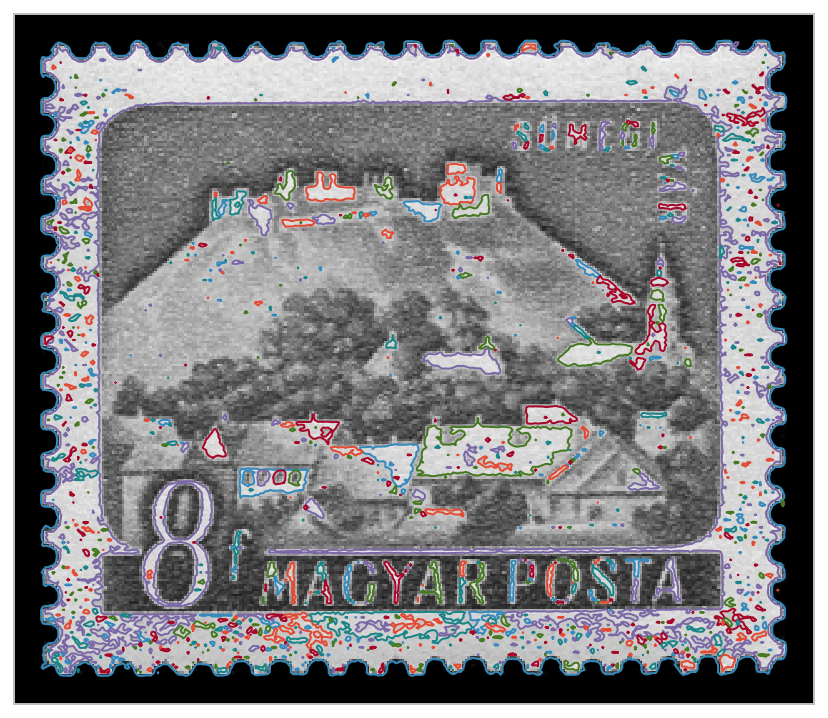

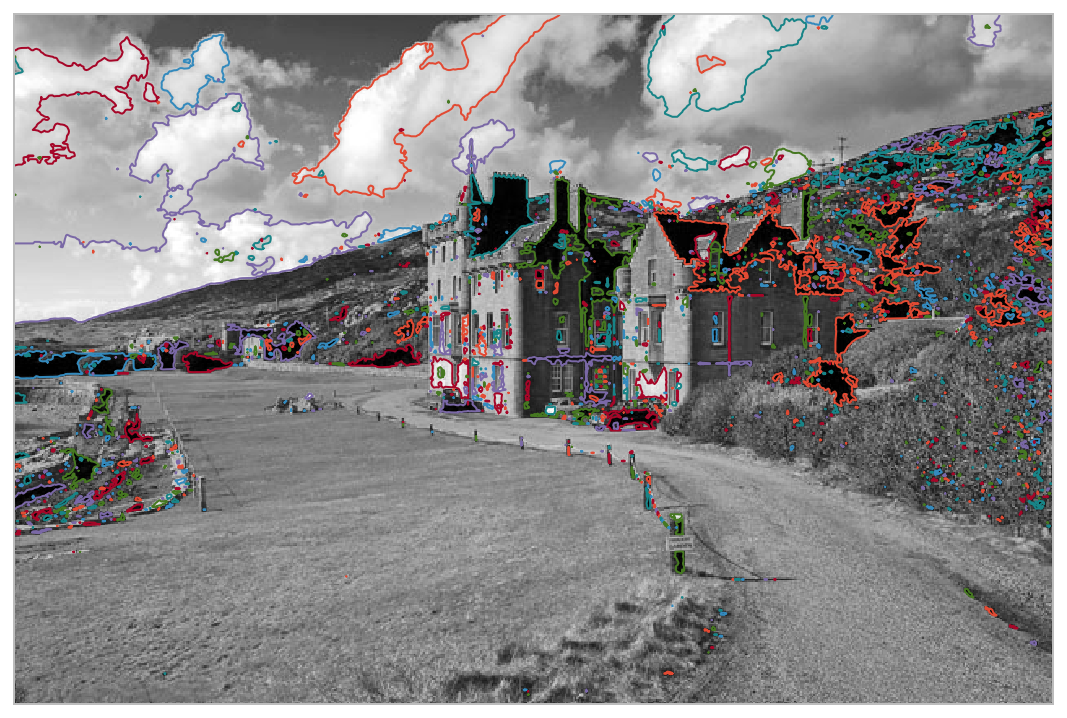

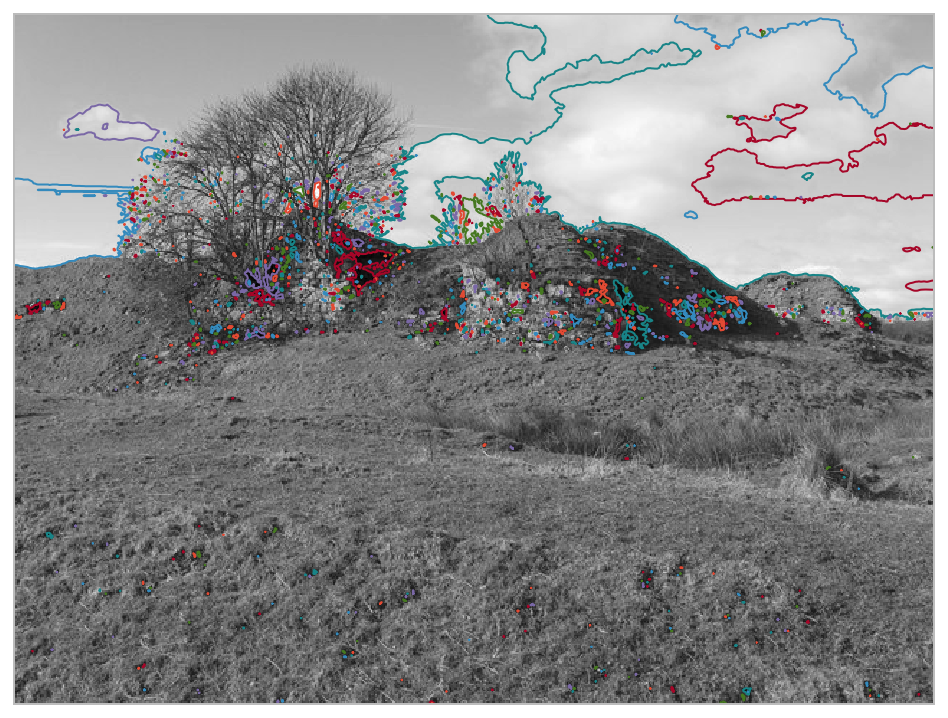

In [28]:
for p in pictures[:3]:
    img, dark, light = find_contours(p)
    plot_contours(img, dark, light)


# Now in parallel

First, we connect our parallel Client

In [30]:
rc = parallel.Client()
all_engines = rc[:]
view = rc.load_balanced_view()

Then we initialize the namespace on all of the engines with imports

In [ ]:
%px import os; os.chdir("{os.getcwd()}")

In [ ]:
%%px
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage import measure

and make sure some functions are defined everywhere (this is only necessary for the `contours_in_url` case)

In [ ]:
all_engines.push(dict(
    plot_contours=plot_contours,
    find_contours=find_contours,
))

Now we can iterate through all of our pictures, and detect and display any faces we find

In [ ]:
from IPython.display import display, Image

amr = view.map_async(get_contours_image, pictures[:20], ordered=False)
for pngdata in amr:
    display(Image(data=pngdata))
